In [ ]:
from sklearn.datasets import make_regression
import numpy as np
import matplotlib.pyplot as plt

## Generate Noisy Data and fit Least Squares

In [ ]:
x, y = make_regression(n_samples=800, n_features=1, noise=15, bias = 30, random_state=42)

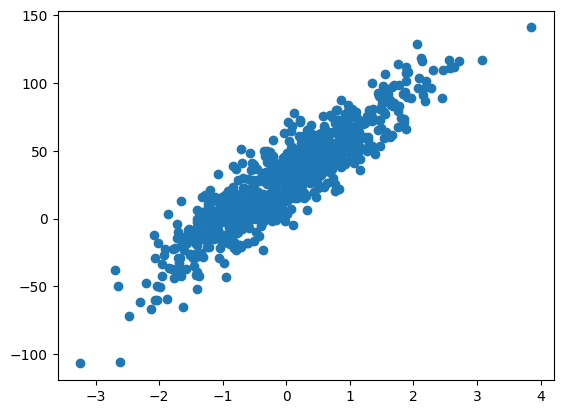

In [ ]:
plt.scatter(x, y)

Fit Least Squares to the data without outliers y = ax + b

In [ ]:
A = np.hstack((x, np.ones((len(x), 1))))
A_pinv = np.linalg.pinv(A)
params = A_pinv@y

In [ ]:
params

array([32.06028708, 29.76937157])

Add outliers

In [ ]:
a = 150
b = -150 + 30

In [ ]:
x_outliers = np.arange(-3, 4, 0.2).reshape(-1,1)
y_outliers = a + (b-a) * np.random.uniform(size = (len(x_outliers),))

In [ ]:
x_noisy = np.vstack((x, x_outliers))
y_noisy = np.concatenate((y, y_outliers), axis = 0).reshape(-1,1)

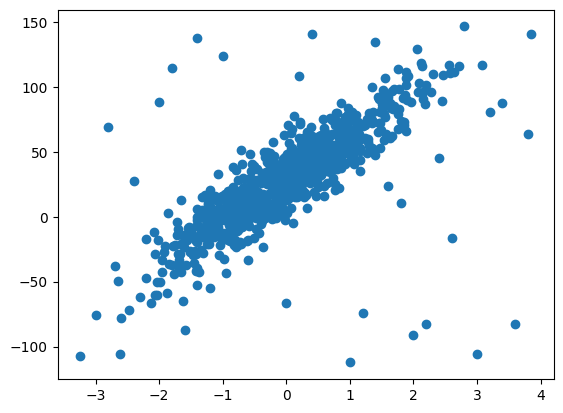

In [ ]:
plt.scatter(x_noisy, y_noisy)

Fit Least Squares to the data with outlierts

In [ ]:
A1 = np.hstack((x_noisy, np.ones((len(x_noisy), 1))))
A1_pinv = np.linalg.pinv(A1)
params1 = A1_pinv@y_noisy

In [ ]:
params1

array([[26.62304594],
       [28.71923698]])

## RANSAC + Least Squares to deal with outliers

In [ ]:
def get_matrices(points, n):
  """
  Create matrices for Least Square Fit
  """
  A = np.hstack((points[:,0].reshape(-1,1), np.ones((n, 1))))
  b = points[:,1]
  return A, b

In [ ]:
def fit_least_squares(A,b):
  """
  Fit Least Squares ofb the form Ax = b, i.e. |Ax-b|^2
  """
  A_pinv = np.linalg.pinv(A)
  params = A_pinv@b
  obj_fun_value = 1/len(A) * np.linalg.norm(A@params - b)**2
  return params, obj_fun_value

In [ ]:
def count_inliers(data, params, t):
  """
  Based on the set threshold t, count inliers in data for particular model fit defined by params
  """
  a, b = params
  inliers_indx = []
  count = 0
  for i in range(len(data)):
    dist = np.abs(a*data[i,0] - data[i,1] + b)/np.sqrt(a**2 + 1)
    if dist <= t:
      inliers_indx.append(i)
      count += 1
  return count, inliers_indx




In [ ]:
def fit_ransac(data, n = 2,  t = 10, iter = 1000, good_fit = 0.7 ):
  """
  data : input data of the shape (N, features + 1)
  n : the least number of points for unambiguously fitting the model (2 for line, 3 form plane, etc.)
  t: threshold for inlier estimation
  iter: max number of iteration before stopping
  good_fit: a fraction of data points as inliers to be considered a good fit
  """
  indx = range(len(data))
  N = int(good_fit*len(data))
  min_obj_fun = np.inf
  best_fit = None
  for _ in range(iter):
    sample_indx = np.random.choice(indx, size = (n,), replace = False)
    # fit Least Squares
    line_params, _  = fit_least_squares(*get_matrices(data[sample_indx], n))
    # count inliers
    count, inliers_indx = count_inliers(data, line_params, t)
    # Fit line to all the inliers when their number is greater good_fit*len(data) and choose best_fit based on the value of the objective_fun
    if count > N:
      line_params, obj_fun = fit_least_squares(*get_matrices(data[inliers_indx], count))
      best_fit = line_params if obj_fun < min_obj_fun else best_fit
  return best_fit

In [ ]:
data = np.hstack((x_noisy, y_noisy))
np.random.shuffle(data)

In [ ]:
best_fit = fit_ransac(data, iter = 2000, t = 3)

In [ ]:
best_fit

array([30.48504608, 29.41215179])

## Visualize results

In [ ]:
x = np.arange(-3, 4, 0.1)
line1 = params[0] * x + params[1]
line2 = params1[0] * x + params1[1]
line3 = best_fit[0]*x + best_fit[1]

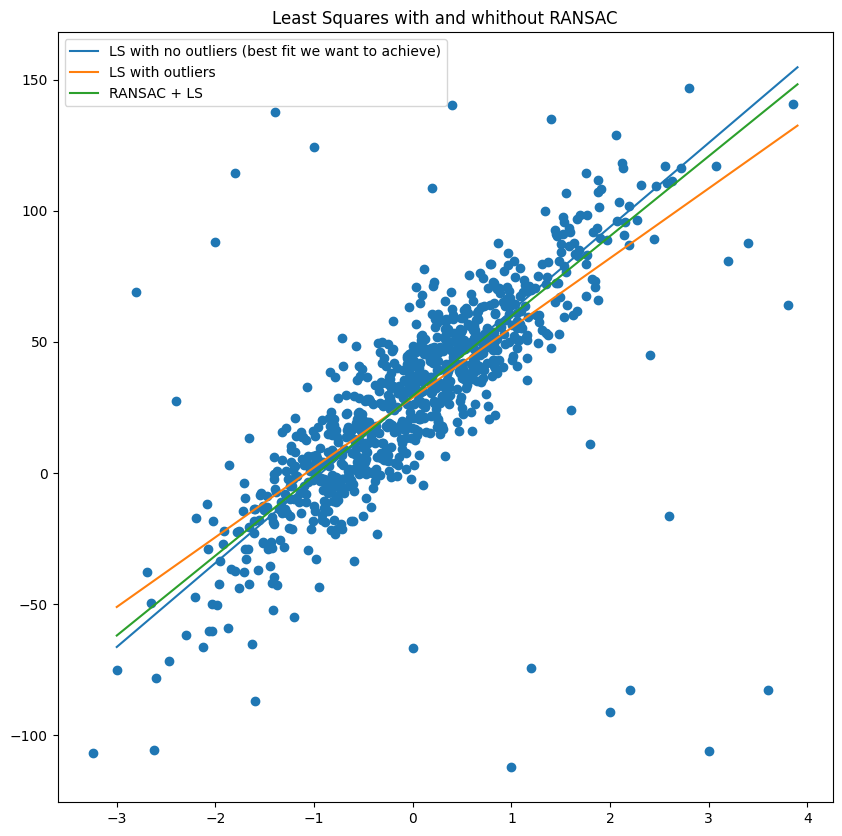

In [ ]:
plt.figure(figsize = (10, 10))
plt.scatter(x_noisy, y_noisy)
plt.plot(x, line1, label = "LS with no outliers (best fit we want to achieve)")
plt.plot(x, line2, label = "LS with outliers")
plt.plot(x, line3, label = "RANSAC + LS")
plt.legend(loc="upper left")
plt.title("Least Squares with and whithout RANSAC")
plt.show()